Import der benötigten Module

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import random

%matplotlib inline

In [ ]:
# Einlesen der Grundwasser-Messdaten im Pickle-Format
df_ms_ws_m = pd.read_pickle("../data/processed/grundwasserdaten-NRW/GW-MesstellenDaten.pkl")

In [3]:
mess_id_error = []
mess_id_in = []
mess_id_in_relevant = []
mess_id_in_irrelevant = []
mess_id_out = []

# Start der Aufzeichnungen
t0 = pd.Timestamp("2009-11-01")
# Um eine ausreichende Datendrundlage zu haben, sollten mindestens 70 Messpunkte vorhanden sein -> empirischer Werte
min_wasserstand_messungen = 70
# Bei jährlichen Änderungen des GW-Pegels um +/-1.5 m/y sehe ich einen technischen Einfluss -> empirischer Werte 
delta_slope_per_year = 1.5
# Wenn die Spannweite größer 40, liegt ein technischer Defekt vor -> empirischer Werte
max_spannweite = 40

df_mess_id_relevant = pd.DataFrame(columns=['slope_m_d', 'slope_m_y', 'intercept_m', 'senkung', 'minimum_m', 'maximum_m', 'spannweite_m', 'anzahl_messpunkte'])
df_mess_id_relevant.index.name = 'messstelle_id'

df_mess_id_irrelevant = pd.DataFrame(columns=['slope_m_d', 'slope_m_y', 'intercept_m', 'senkung', 'minimum_m', 'maximum_m', 'spannweite_m', 'anzahl_messpunkte'])
df_mess_id_irrelevant.index.name = 'messstelle_id'

for mess_id in df_ms_ws_m.loc[:, 'messstelle_id'].unique().tolist():

    mess_id_mask = df_ms_ws_m.loc[:, 'messstelle_id'] == mess_id
    df_mess_id = df_ms_ws_m[mess_id_mask]
    df_mess_id = df_mess_id.sort_values('datum_messung')
    df_mess_id["t"] = (df_mess_id["datum_messung"] - t0).dt.days

    try:
        if len(df_mess_id) > min_wasserstand_messungen:
            mess_id_in.append(mess_id)
            # Lineare Regression
            model_wasserstd_t = smf.ols(formula='wasserstd_m ~ t', data=df_mess_id)
            results = model_wasserstd_t.fit()
               
            messstelle = {
                'slope_m_d': results.params["t"],
                'slope_m_y': results.params["t"] * 365.25,
                'intercept_m': results.params["Intercept"],
                'senkung': False,
                'minimum_m': df_mess_id.loc[:, 'wasserstd_m'].min(),
                'maximum_m': df_mess_id.loc[:, 'wasserstd_m'].max(),
                'spannweite_m': 0.0,
                'anzahl_messpunkte': len(df_mess_id),
            }
                    
            if messstelle['slope_m_d'] >= 0:
                messstelle['senkung'] = False
            else:
                messstelle['senkung'] = True
            
            messstelle['spannweite_m'] = messstelle['maximum_m'] - messstelle['minimum_m']

            # Ausnahme von Ausreißern und Extermwerten
            if abs(messstelle['slope_m_y']) <= delta_slope_per_year and messstelle['spannweite_m'] < max_spannweite:
                mess_id_in_relevant.append(mess_id)
                df_mess_id_relevant.loc[mess_id] = messstelle
            else:
                mess_id_in_irrelevant.append(mess_id)
                df_mess_id_irrelevant.loc[mess_id] = messstelle
        else:
            mess_id_out.append(mess_id)
    except ValueError:
        mess_id_error.append(mess_id)
    except IndexError:
        mess_id_error.append(mess_id)

if len(mess_id_error) > 0:
    print(f'Anzahl Fehler: {len(mess_id_error)}')
    print(mess_id_error)

In [4]:
total_messstellen = len(mess_id_in) + len(mess_id_out)
print(f'Gesamtanzahl der Grundwasser-Messstellen: {total_messstellen}')
print(f'------------------------------------------')
print(f'Grenze der Mindestanzahl an Messpunkten: {min_wasserstand_messungen}')
print(f'\tinnerhalb: {len(mess_id_in)}  -> {len(mess_id_in)/total_messstellen*100:.1f}%')
print(f'\taußerhalb: {len(mess_id_out)}  -> {len(mess_id_out)/total_messstellen*100:.1f}%\n')
print(f'Nähere Betrachtung der {len(mess_id_in)} interessanten Messtellen')
print(f'\tbetrachteter Antieg max. +/-{delta_slope_per_year}m pro Jahr')
print(f'\tbetrachtete Spannweite max. {max_spannweite}m')
print(f'\t\tinnerhalb: {len(mess_id_in_relevant)}  -> {len(mess_id_in_relevant)/len(mess_id_in)*100:.1f}%')
print(f'\t\taußerhalb: {len(mess_id_in_irrelevant)}  -> {len(mess_id_in_irrelevant)/len(mess_id_in)*100:.1f}%\n')
print(f'Resultierend zu analaysierende Messstellen: {len(mess_id_in_relevant)}  -> {len(mess_id_in_relevant)/total_messstellen*100:.1f}%')

Gesamtanzahl der Grundwasser-Messstellen: 11348
------------------------------------------
Grenze der Mindestanzahl an Messpunkten: 70
	innerhalb: 10036  -> 88.4%
	außerhalb: 1312  -> 11.6%

Nähere Betrachtung der 10036 interessanten Messtellen
	betrachteter Antieg max. +/-1.5m pro Jahr
	betrachtete Spannweite max. 40m
		innerhalb: 9958  -> 99.2%
		außerhalb: 78  -> 0.8%

Resultierend zu analaysierende Messstellen: 9958  -> 87.8%


In [5]:
df_mess_id_relevant.head(20)

,slope_m_d,slope_m_y,intercept_m,senkung,minimum_m,maximum_m,spannweite_m,anzahl_messpunkte
messstelle_id,,,,,,,,
70283916,0.000183,0.067013,157.766118,False,157.389999,159.130005,1.740005,137
10445730,-0.000492,-0.179650,31.210349,True,26.799999,30.820000,4.020000,2250
10445791,-0.000170,-0.062256,31.152236,True,30.170000,31.610001,1.440001,2207
10446722,0.000207,0.075724,80.778631,False,80.760002,81.589996,0.829994,1705
100151115,0.000043,0.015632,39.662841,False,38.310001,40.500000,2.189999,120
100604936,0.000441,0.160962,40.893900,False,40.740002,41.310001,0.570000,198
21661157,0.000302,0.110219,168.002811,False,166.750000,174.149994,7.399994,120
63005803,-0.000167,-0.061076,24.415579,True,23.440001,25.660000,2.219999,115
63000520,-0.000161,-0.058666,46.608161,True,45.220001,47.869999,2.649998,112


In [6]:
df_mess_id_relevant["senkung"].value_counts()


senkung
True     8409
False    1549
Name: count, dtype: int64

In [7]:
df_mess_id_relevant.describe()

,slope_m_d,slope_m_y,intercept_m,minimum_m,maximum_m,spannweite_m,anzahl_messpunkte
count,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000
mean,-0.000130,-0.047457,71.616232,70.109146,72.903297,2.794150,379.649930
std,0.000343,0.125455,58.078130,57.770016,58.607944,3.188889,734.959361
min,-0.004075,-1.488518,-176.766913,-179.869995,-176.559998,0.020000,71.000000
25%,-0.000191,-0.069720,38.014681,36.822500,39.172499,1.320000,114.000000
50%,-0.000101,-0.036857,50.188308,48.809999,51.350000,1.870003,120.000000
75%,-0.000034,-0.012305,89.492341,88.650002,90.737499,3.020004,176.000000
max,0.004047,1.478314,538.288422,536.640015,541.390015,39.389999,3652.000000


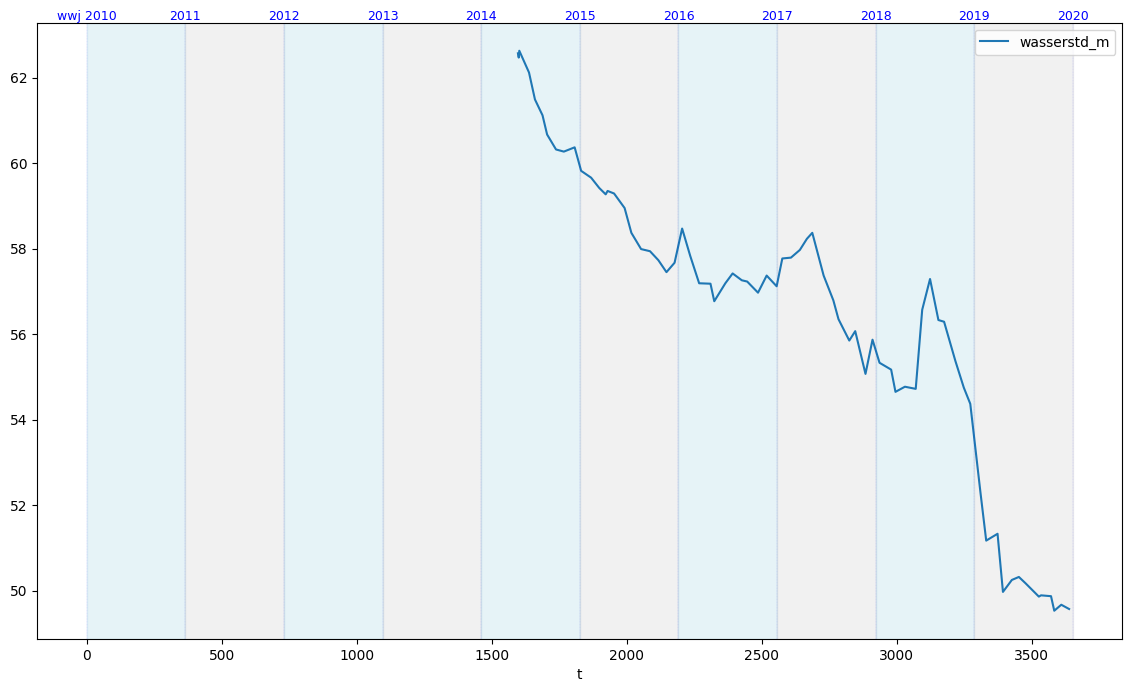

In [34]:
fig, ax = plt.subplots(figsize=[14, 8], nrows=1, ncols=1)

test_mask = df_ms_ws_m.loc[:, 'messstelle_id'] == random.choice(mess_id_in_irrelevant) # 70283916

df_m70283916 = df_ms_ws_m[test_mask]

df_m70283916 = df_m70283916.sort_values('datum_messung')

t0 = pd.Timestamp("2009-11-01")

df_m70283916["t"] = (df_m70283916["datum_messung"] - t0).dt.days

df_m70283916.plot(kind='line', x='t', y='wasserstd_m', ax=ax);

tage_pro_jahr = 365.25
startjahr = 2010

for jahr in range(10):
    start = jahr * tage_pro_jahr
    ende = (jahr + 1) * tage_pro_jahr

    ax.axvspan(start, ende, 
               color=("lightblue" if jahr % 2 == 0 else "lightgray"),
               alpha=0.3)

for jahr in range(11):   # 10 Jahre = 11 Marken
    x_pos = jahr * tage_pro_jahr
    ax.axvline(x=x_pos, color="blue", linestyle=":", alpha=0.7, linewidth=0.2)

    if jahr == 0:
        ax.text(
            x_pos,                          # x-Position
            ax.get_ylim()[1],               # y-Position (oben)
            'wwj ' + str(startjahr + jahr), # Text
            ha="center", va="bottom",       # horizontale/vertikale Ausrichtung
            fontsize=9, color="blue"
        )
    else:
        ax.text(
            x_pos,                          # x-Position
            ax.get_ylim()[1],               # y-Position (oben)
            str(startjahr + jahr),          # Text
            ha="center", va="bottom",       # horizontale/vertikale Ausrichtung
            fontsize=9, color="blue"
        )




In [9]:
df_m70283916.head(3)

,messstelle_id,name,e32,n32,turnus_wasserstand,freigabe_wstd,freigabe_chemie,freigabe_lage,messstellenart,messstelle_sl_nr,datum_messung,abstich_m,hinweis,wasserstd_m,flurabstd_m,mph_m,gok_m,wwj,t
1634830,20884138,13 PSA GUETERS,4518XX,57527XX,monatlich,ja,nein,nein,GW-Messstelle,3126,2017-04-11,2.37,-,65.440002,2.56,67.809998,68.0,2017,2718
1634831,20884138,13 PSA GUETERS,4518XX,57527XX,monatlich,ja,nein,nein,GW-Messstelle,3126,2017-05-03,2.51,-,65.300003,2.70,67.809998,68.0,2017,2740
1634832,20884138,13 PSA GUETERS,4518XX,57527XX,monatlich,ja,nein,nein,GW-Messstelle,3126,2017-06-08,2.60,-,65.209999,2.79,67.809998,68.0,2017,2776


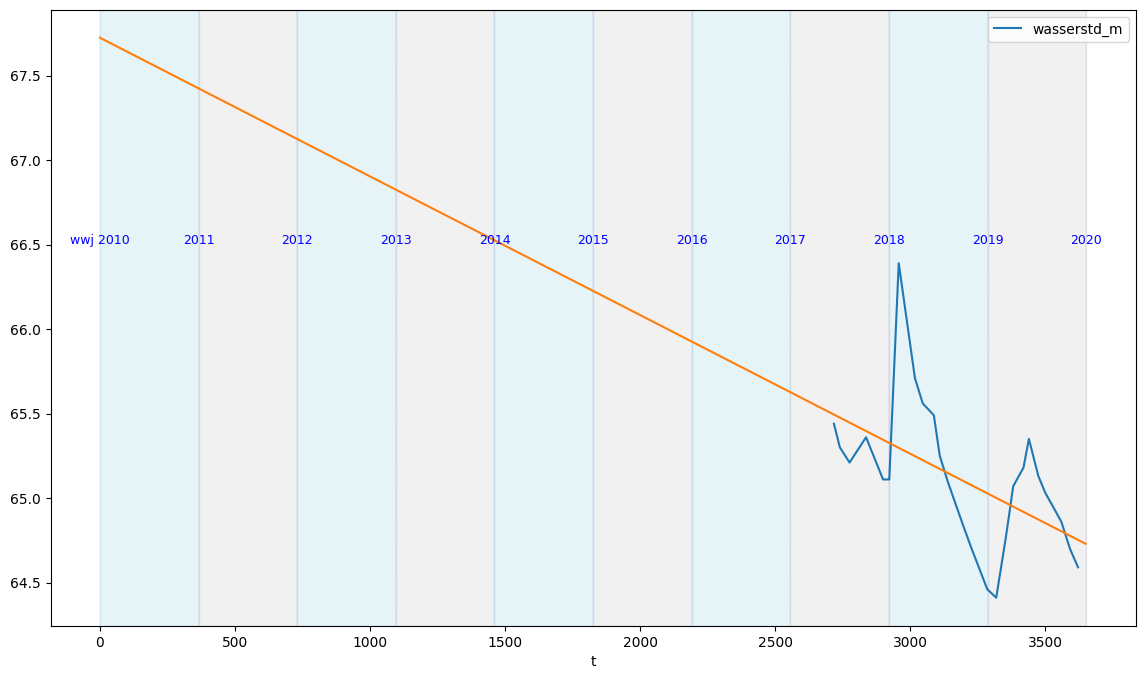

In [10]:
model_rating_abv = smf.ols(formula='wasserstd_m ~ t', data=df_m70283916)

results = model_rating_abv.fit()

results.summary()

(results.predict(pd.DataFrame({"t": range(3651)}))).plot(ax=ax)

fig

In [11]:
intercept = results.params["Intercept"]
slope     = results.params["t"]

print(f"Intercept: {intercept}")
print(f"Anstieg:   {slope}")

Intercept: 67.72465786236485
Anstieg:   -0.0008206325639482787


<Axes: >

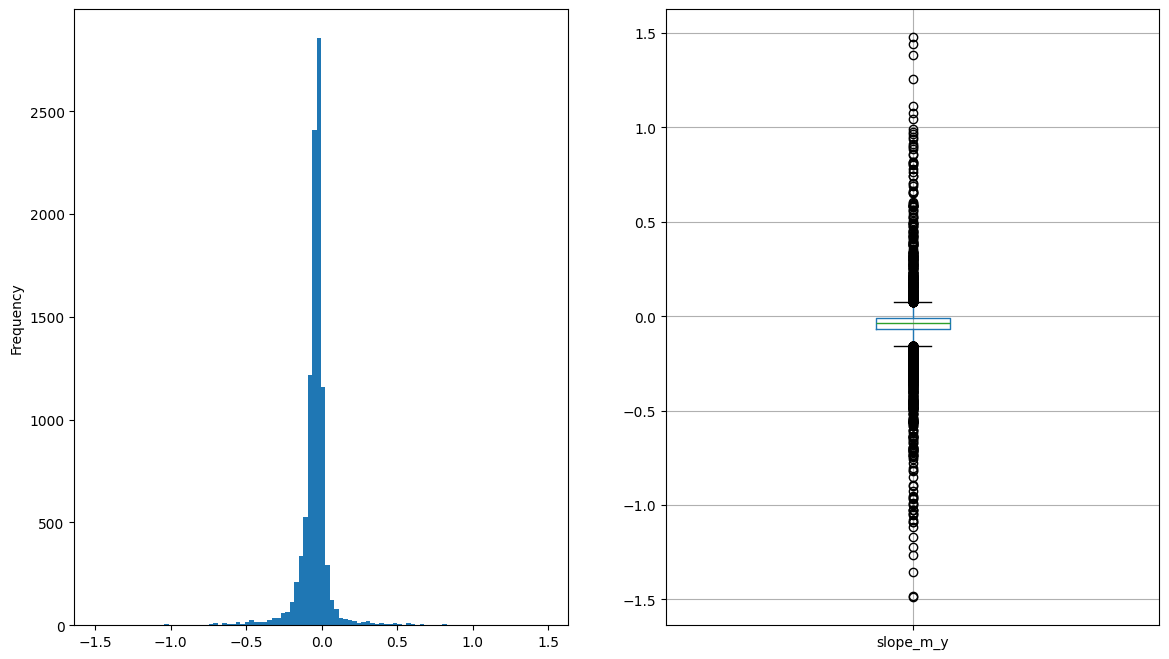

In [14]:
fig, ax = plt.subplots(figsize=[14, 8], nrows=1, ncols=2)

df_mess_id_relevant['slope_m_y'].plot(kind='hist', bins=100, ax=ax[0]);

df_mess_id_relevant.boxplot(
    column="slope_m_y",
    # by="senkung",
    grid=True,
    ax=ax[1]
)

In [16]:
df_dd_mask = (df_mess_id_relevant.loc[:, 'spannweite_m'] > 35)

df_mess_id_relevant[df_dd_mask]

,slope_m_d,slope_m_y,intercept_m,senkung,minimum_m,maximum_m,spannweite_m,anzahl_messpunkte
messstelle_id,,,,,,,,
10421385,-0.001042,-0.380651,254.543067,True,237.360001,274.559998,37.199997,3137
96000090,-0.001739,-0.635097,342.480886,True,330.450012,368.640015,38.190002,296
10421579,-0.001475,-0.538620,224.730592,True,191.160004,229.330002,38.169998,248
10406918,-0.000321,-0.117063,55.673000,True,44.270000,80.839996,36.569996,511
10405719,0.001313,0.479695,250.007336,False,233.800003,272.950012,39.150009,91
100732112,-0.000207,-0.075498,41.509498,True,39.410000,76.279999,36.869999,107
10203291,-0.001313,-0.479433,510.902836,True,491.600006,528.539978,36.939972,116
91168600,-0.001939,-0.708100,361.277465,True,344.959991,382.279999,37.320007,3399
73568820,-0.002733,-0.998201,42.156070,True,1.060000,40.360001,39.299999,435
